# Imagining the Future:
# Science Fiction Films Through Time
Science fiction films both represent what we aspire to be and do, while also reflect our current fears and concerns. In this project I scraped every science fiction film since 1920 with a Wikipedia entry. I used Natural Language Processing to examine word use over time. I also built a companion app that plots word usage over time, similar in spirit to the Google NGram project. I also tried using both static and dynamic topic modeling, but the findings were not particularly enlightening. However the code is included for those interested in using the method for other projects.

In [1]:
import pandas as pd
import time
import numpy as np
import gensim
from gensim import corpora, models
import pyLDAvis.gensim
from gensim import corpora
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from stop_words import get_stop_words
import matplotlib.pyplot as plt

In [2]:
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',200)

In [3]:
df = pd.read_pickle('/Users/Alexander/GA/data_capstone/scrapings/wiki_11_1748.pkl')

In [4]:
df.reset_index(inplace=True)
# did eda on missing country names. using my subject matter expertise on sci-fi films, I looked through the 100 films
# and identified the significant ones to actually keep in the df. Drop everything else.
df.at[1257,'country'] = 'United States'
df.at[1138,'country'] = 'United States'
print('Shape of Datframe:')
print(df.shape)
print('Number of observations missing country:')
print(df.country.isnull().sum())
print('Dropping...')
df = df[df.country.isnull() != True]
print('New shape of dataframe:')
print(df.shape)
df.country = [i.lower().lstrip(' ').rstrip(' ') for i in df.country]
df.drop('index',1,inplace=True)

Shape of Datframe:
(1748, 8)
Number of observations missing country:
108
Dropping...
New shape of dataframe:
(1640, 8)


In [5]:
germany = ['weimar republic','germany','nazi germany','east germany',
'west germany','germany, hungary, france']
us = ['united states','united states','usa',
'united states/new zealand','us / ussr']
russia = ['soviet union','russia']
nan = ['director: a. kasilingam','kelley bohanon as karen braden','vsevolod yakut',
'the zentradi males and females are named zentran and meltran and placed on opposite sides of the protoculture conflict. no mention is made of the',
'richard ruxton as joe montague','2005 best film – new york city horror film festival','1964:',
'issei takahashi as yōji','']
yugoslavia = ['sfr yugoslavia','yugoslavia']
australia = ['australia, italy', 'australia']
italy = ['italy, france','italy']
uk = ['united kingdom, united states','united kingdom']
countries = []
for i in df.country:
    if i in germany:
        country = 'germany'
    elif i in us:
        country = 'united states'
    elif i in russia:
        country = 'russia'
    elif i in nan:
        country = np.NaN
    elif i in yugoslavia:
        country = 'yugoslavia'
    elif i in australia:
        country = 'australia'
    elif i in italy:
        country = 'italy'
    elif i in uk:
        country = 'united kingdom'
    else:
        country = i
    countries.append(country)
df.country = countries

In [6]:
years = []
for i in df.year:
    try:
        i = i.split('-')[0]
    except:
        i
    try:
        if i.isdigit() and len(i)>3:
            year = float((i[:4]))
        else:
            year=np.NaN
    except:
        year = np.NaN
    years.append(year)
df.year = years
df = df[df.year<2017]
print(df.shape)
df = df[df.country != 'japan']
df.shape

(1504, 7)


(1363, 7)

In [7]:
df.country.value_counts().head()

united states     926
united kingdom    119
canada             34
france             34
germany            31
Name: country, dtype: int64

In [8]:
df.to_pickle('/Users/Alexander/GA/data_capstone/cleaned_wiki.pkl')

In [9]:
df = pd.read_pickle('/Users/Alexander/GA/data_capstone/cleaned_wiki.pkl')

In [10]:
important_words = ['nuclear','robot','planet','space','android','machine','rocket','alien','mars','moon','satellite',
                  'spaceship','ship','scientist','laboratory','professor','dr.','saucer', 'computer',
                  'future','military','soldier', 'monster','earth','planet','police','internet','television',
                  'screen','phone','radio','artificial','genetic','atomic','laser','galaxy','quantum','intelligence','fusion',
                  'cyber','drone','phaser','genius','martian','army','missile','lab ','factory','jet','disease','spy','officer',
                  'warrior','government','rebellion', 'russian','soviet','chinese','nazi','fascist','war','combat',
                  'exterminat','illness','epidemic','native','peace','battle','surviv', 
                   'global warming', 'climate change','disaster','astronaut']

In [11]:
for word in important_words:
    df['{}'.format(word)] = [1 if word in i.lower() else 0 for i in df.synopsis]

In [12]:
df.tail()

,title,link,summary,year,decade,country,synopsis,nuclear,robot,planet,space,android,machine,rocket,alien,mars,moon,satellite,spaceship,ship,scientist,laboratory,professor,dr.,saucer,computer,future,military,soldier,monster,earth,police,internet,television,screen,phone,radio,artificial,genetic,atomic,laser,galaxy,quantum,intelligence,fusion,cyber,drone,phaser,genius,martian,army,missile,lab,factory,jet,disease,spy,officer,warrior,government,rebellion,russian,soviet,chinese,nazi,fascist,war,combat,exterminat,illness,epidemic,native,peace,battle,surviv,global warming,climate change,disaster,astronaut
1689,Star Trek Beyond,https://en.wikipedia.org/wiki/Star_Trek_Beyond,Star Trek Beyond is a 2016 American science fi...,2016.0,2010,united states,"Three years into its mission, the USS Enterpri...",0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
1690,Teenage Mutant Ninja Turtles: Out of the Shado...,https://en.wikipedia.org/wiki/Teenage_Mutant_N...,Teenage Mutant Ninja Turtles: Out of the Shado...,2016.0,2010,united states,Two years after their battle with Shredder and...,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1692,X-Men: Apocalypse,https://en.wikipedia.org/wiki/X-Men:_Apocalypse,X-Men: Apocalypse is a 2016 American superhero...,2016.0,2010,united states,"En Sabah Nur, a powerful mutant believed to be...",1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1713,Resident Evil: The Final Chapter,https://en.wikipedia.org/wiki/Resident_Evil:_T...,Resident Evil: The Final Chapter is a 2016 sci...,2016.0,2010,germany,"Dr. James Marcus, the original founder of the ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1746,Star Wars: Episode IX,https://en.wikipedia.org/wiki/Star_Wars:_Episo...,The Star Wars Sequel Trilogy is the third set ...,2015.0,2010,united states,"A daring synthetic biologist who, after a car ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_decades = df.groupby('decade').sum().drop('year',1)
df_decades.head(10)

,nuclear,robot,planet,space,android,machine,rocket,alien,mars,moon,satellite,spaceship,ship,scientist,laboratory,professor,dr.,saucer,computer,future,military,soldier,monster,earth,police,internet,television,screen,phone,radio,artificial,genetic,atomic,laser,galaxy,quantum,intelligence,fusion,cyber,drone,phaser,genius,martian,army,missile,lab,factory,jet,disease,spy,officer,warrior,government,rebellion,russian,soviet,chinese,nazi,fascist,war,combat,exterminat,illness,epidemic,native,peace,battle,surviv,global warming,climate change,disaster,astronaut
decade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1920,0,1,2,4,0,4,5,0,2,3,0,1,9,5,3,5,3,0,0,0,0,1,0,7,5,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,2,1,0,0,0,0,0,0,1,0,1,0,0,0,10,1,0,0,0,0,1,1,4,0,0,0,0
1930,0,4,5,5,0,8,4,1,5,2,0,0,8,15,12,5,24,0,0,2,3,0,2,9,10,0,0,0,4,4,3,0,1,0,1,0,1,1,0,0,0,1,2,4,0,3,0,0,1,0,1,0,3,0,0,1,0,0,0,26,0,0,0,1,1,4,3,10,0,0,3,0
1940,0,3,3,5,0,3,5,2,4,4,0,5,8,17,9,10,23,2,0,0,0,0,6,8,6,0,0,0,3,3,0,0,5,0,0,0,1,2,0,0,0,1,4,4,0,2,1,2,1,3,1,0,4,0,0,1,0,2,0,14,0,0,0,0,3,0,5,4,0,0,0,0
1950,23,11,31,54,0,14,25,32,17,13,5,22,54,70,14,21,66,14,8,12,19,6,26,70,29,0,6,12,12,39,5,0,29,1,1,0,2,4,0,0,0,2,10,14,7,13,2,9,5,6,16,0,19,0,6,4,1,6,0,84,3,2,0,1,6,14,9,42,0,1,8,7
1960,21,6,24,41,1,16,11,26,14,17,7,20,46,42,6,11,42,1,10,20,20,6,13,51,16,1,8,7,5,14,2,4,3,4,5,0,8,4,0,0,0,5,7,5,10,8,2,5,4,8,10,0,14,0,5,12,1,3,0,54,1,1,0,1,6,9,7,27,0,0,2,19
1970,17,26,42,50,8,18,6,29,5,9,4,19,59,36,12,11,37,6,21,26,12,7,6,59,29,0,13,6,11,20,8,7,2,10,6,0,5,5,0,4,0,2,0,9,4,9,2,6,6,8,18,8,19,2,2,4,2,5,0,76,4,3,2,3,3,9,19,51,1,0,6,10
1980,32,31,59,73,13,33,13,63,11,23,11,32,90,40,24,10,59,4,38,46,27,26,24,79,62,0,19,10,24,24,10,18,5,20,13,0,13,9,5,3,0,4,2,23,15,20,10,11,2,5,32,7,35,2,2,7,2,4,1,142,9,4,1,0,7,18,42,72,1,0,9,6
1990,21,20,49,52,13,29,10,43,13,14,11,16,75,36,15,13,55,5,36,30,25,22,7,62,44,1,5,8,7,15,14,19,4,7,6,1,12,7,12,0,3,2,5,21,9,14,4,15,10,6,38,8,30,2,3,3,3,5,1,124,14,3,3,1,9,16,38,72,2,1,4,10
2000,27,33,55,70,7,45,9,53,16,12,12,21,92,49,17,15,51,0,30,47,55,30,14,83,55,4,16,10,26,25,14,26,1,6,6,1,17,6,9,9,1,5,3,36,17,9,12,18,11,5,27,6,43,2,14,6,8,2,1,153,8,8,3,4,6,17,55,87,1,0,10,12


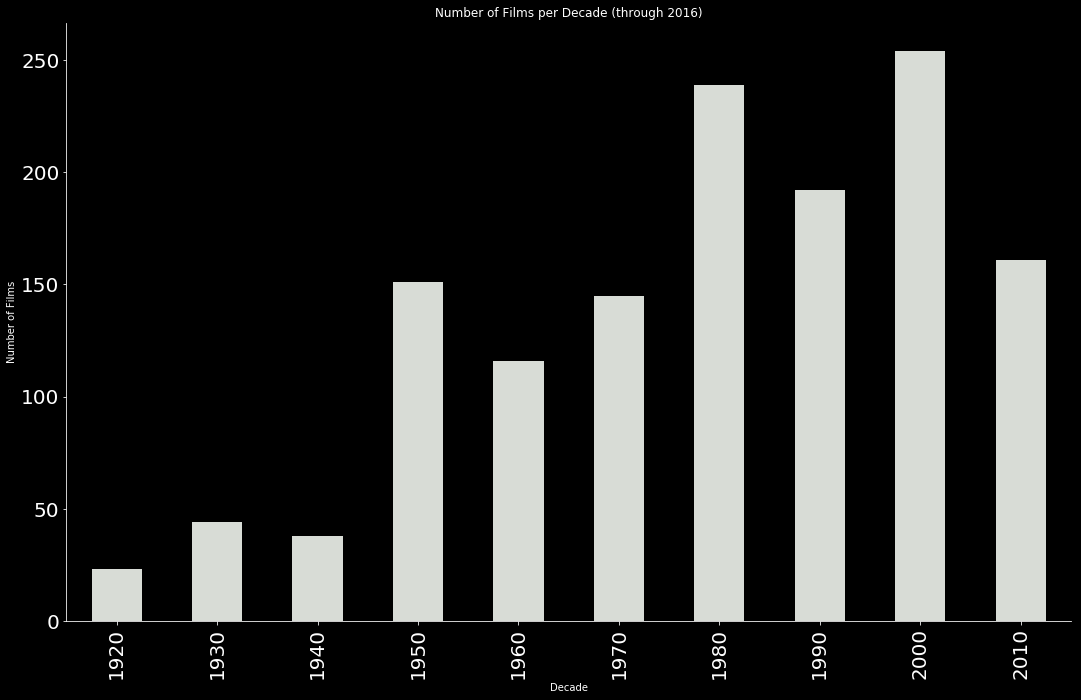

In [14]:
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 25}


plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = 18, 11
ax = df.groupby('decade').title.count().plot(kind = 'bar', color="xkcd:light grey")
plt.xlabel('Decade')
plt.ylabel('Number of Films')
plt.title('Number of Films per Decade (through 2016)')
plt.grid(False)
plt.rc('font', **font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.axis('off')
plt.savefig('number_of_films.png')
plt.show()

In [ ]:
decade_simple = ['1920','1930','1940','1950','1960','1970','1980','1990','2000','2010']

In [16]:
df_percentages = round(df_decades/df.groupby('decade').count()*100)
df_percentages.drop(['country','summary','synopsis','title','year','link'],axis=1,inplace=True)

In [17]:
df_percentages

,alien,android,army,artificial,astronaut,atomic,battle,chinese,climate change,combat,computer,cyber,disaster,disease,dr.,drone,earth,epidemic,exterminat,factory,fascist,fusion,future,galaxy,genetic,genius,global warming,government,illness,intelligence,internet,jet,lab,laboratory,laser,machine,mars,martian,military,missile,monster,moon,native,nazi,nuclear,officer,peace,phaser,phone,planet,police,professor,quantum,radio,rebellion,robot,rocket,russian,satellite,saucer,scientist,screen,ship,soldier,soviet,space,spaceship,spy,surviv,television,war,warrior
decade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1920,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,13.0,0.0,30.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,9.0,13.0,0.0,17.0,9.0,4.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,9.0,22.0,22.0,0.0,0.0,4.0,4.0,22.0,0.0,0.0,0.0,22.0,0.0,39.0,4.0,4.0,17.0,4.0,0.0,17.0,4.0,43.0,0.0
1930,2.0,0.0,9.0,7.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,55.0,0.0,20.0,2.0,0.0,0.0,0.0,2.0,5.0,2.0,0.0,2.0,0.0,7.0,0.0,2.0,0.0,0.0,7.0,27.0,0.0,18.0,11.0,5.0,7.0,0.0,5.0,5.0,2.0,0.0,0.0,2.0,9.0,0.0,9.0,11.0,23.0,11.0,0.0,9.0,0.0,9.0,9.0,0.0,0.0,0.0,34.0,0.0,18.0,0.0,2.0,11.0,0.0,0.0,23.0,0.0,59.0,0.0
1940,5.0,0.0,11.0,0.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,61.0,0.0,21.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,3.0,0.0,5.0,5.0,24.0,0.0,8.0,11.0,11.0,0.0,0.0,16.0,11.0,8.0,5.0,0.0,3.0,0.0,0.0,8.0,8.0,16.0,26.0,0.0,8.0,0.0,8.0,13.0,0.0,0.0,5.0,45.0,0.0,21.0,0.0,3.0,13.0,13.0,8.0,11.0,0.0,37.0,0.0
1950,21.0,0.0,9.0,3.0,5.0,19.0,6.0,1.0,1.0,2.0,5.0,0.0,5.0,3.0,44.0,0.0,46.0,1.0,1.0,1.0,0.0,3.0,8.0,1.0,0.0,1.0,0.0,13.0,0.0,1.0,0.0,6.0,9.0,9.0,1.0,9.0,11.0,7.0,13.0,5.0,17.0,9.0,4.0,4.0,15.0,11.0,9.0,0.0,8.0,21.0,19.0,14.0,0.0,26.0,0.0,7.0,17.0,4.0,3.0,9.0,46.0,8.0,36.0,4.0,3.0,36.0,15.0,4.0,28.0,4.0,56.0,0.0
1960,22.0,1.0,4.0,2.0,16.0,3.0,6.0,1.0,0.0,1.0,9.0,0.0,2.0,3.0,36.0,0.0,44.0,1.0,1.0,2.0,0.0,3.0,17.0,4.0,3.0,4.0,0.0,12.0,0.0,7.0,1.0,4.0,7.0,5.0,3.0,14.0,12.0,6.0,17.0,9.0,11.0,15.0,5.0,3.0,18.0,9.0,8.0,0.0,4.0,21.0,14.0,9.0,0.0,12.0,0.0,5.0,9.0,4.0,6.0,1.0,36.0,6.0,40.0,5.0,10.0,35.0,17.0,7.0,23.0,7.0,47.0,0.0
1970,20.0,6.0,6.0,6.0,7.0,1.0,13.0,1.0,0.0,3.0,14.0,0.0,4.0,4.0,26.0,3.0,41.0,2.0,2.0,1.0,0.0,3.0,18.0,4.0,5.0,1.0,1.0,13.0,1.0,3.0,0.0,4.0,6.0,8.0,7.0,12.0,3.0,0.0,8.0,3.0,4.0,6.0,2.0,3.0,12.0,12.0,6.0,0.0,8.0,29.0,20.0,8.0,0.0,14.0,1.0,18.0,4.0,1.0,3.0,4.0,25.0,4.0,41.0,5.0,3.0,34.0,13.0,6.0,35.0,9.0,52.0,6.0
1980,26.0,5.0,10.0,4.0,3.0,2.0,18.0,1.0,0.0,4.0,16.0,2.0,4.0,1.0,25.0,1.0,33.0,0.0,2.0,4.0,0.0,4.0,19.0,5.0,8.0,2.0,0.0,15.0,0.0,5.0,0.0,5.0,8.0,10.0,8.0,14.0,5.0,1.0,11.0,6.0,10.0,10.0,3.0,2.0,13.0,13.0,8.0,0.0,10.0,25.0,26.0,4.0,0.0,10.0,1.0,13.0,5.0,1.0,5.0,2.0,17.0,4.0,38.0,11.0,3.0,31.0,13.0,2.0,30.0,8.0,59.0,3.0
1990,22.0,7.0,11.0,7.0,5.0,2.0,20.0,2.0,1.0,7.0,19.0,6.0,2.0,5.0,29.0,0.0,32.0,1.0,2.0,2.0,1.0,4.0,16.0,3.0,10.0,1.0,1.0,16.0,2.0,6.0,1.0,8.0,7.0,8.0,4.0,15.0,7.0,3.0,13.0,5.0,4.0,7.0,5.0,3.0,11.0,20.0,8.0,2.0,4.0,26.0,23.0,7.0,1.0,8.0,1.0,10.0,5.0,2.0,6.0,3.0,19.0,4.0,39.0,11.0,2.0,27.0,8.0,3.0,38.0,3.0,65.0,4.0
2000,21.0,3.0,14.0,6.0,5.0,0.0,22.0,3.0,0.0,3.0,12.0,4.0,4.0,4.0,20.0,4.0,33.0,2.0,3.0,5.0,0.0,2.0,19.0,2.0,10.0,2.0,0.0,17.0,1.0,7.0,2.0,7.0,4.0,7.0,2.0,18.0,6.0,1.0,22.0,7.0,6.0,5.0,2.0,1.0,11.0,11.0,7.0,0.0,10.0,22.0,22.0,6.0,0.0,10.0,1.0,13.0,4.0,6.0,5.0,0.0,19.0,4.0,36.0,12.0,2.0,28.0,8.0,2.0,34.0,6.0,60.0,2.0


In [18]:
beings = ['alien','robot','martian']
people = ['dr.','scientist','soldier','astronaut']
devices = ['computer','radio','artificial','rocket']
vehicles = ['rocket','saucer','spaceship','ship']
concepts = ['atomic','future','genetic','space']
war = ['war','battle','peace']
entities = ['military','army','war']

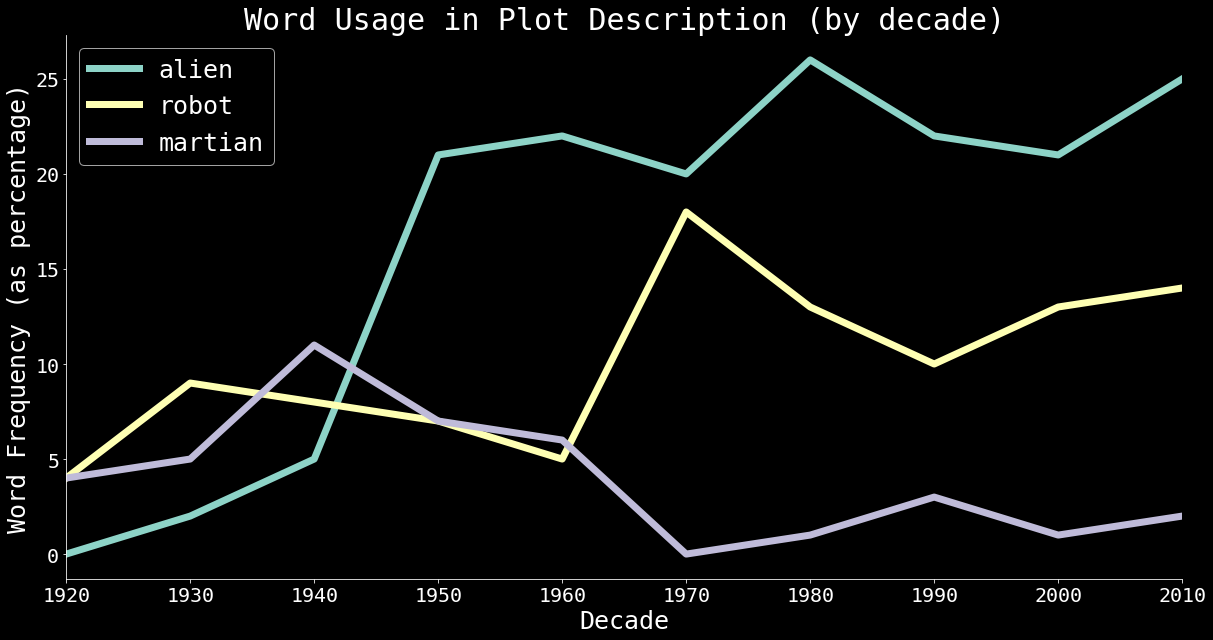

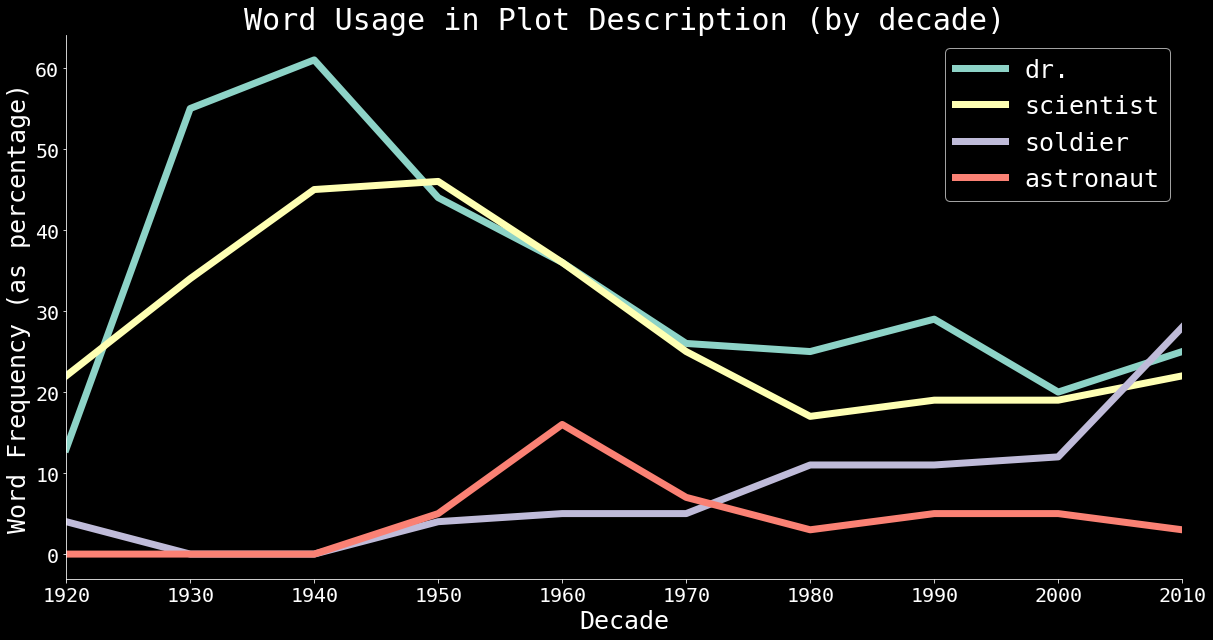

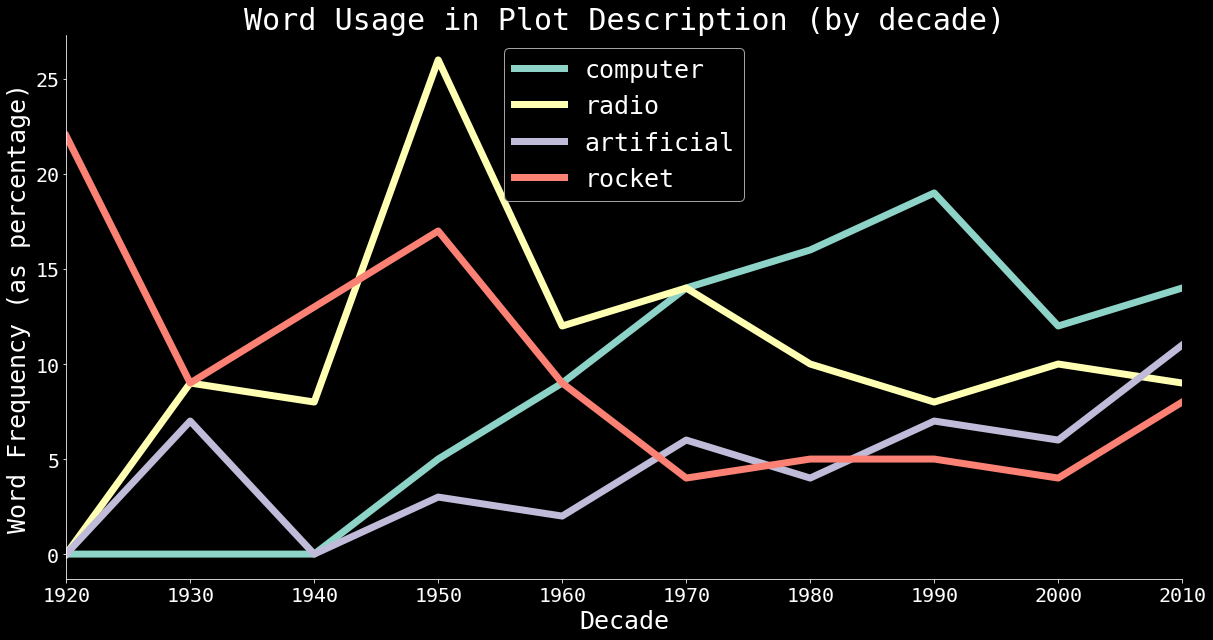

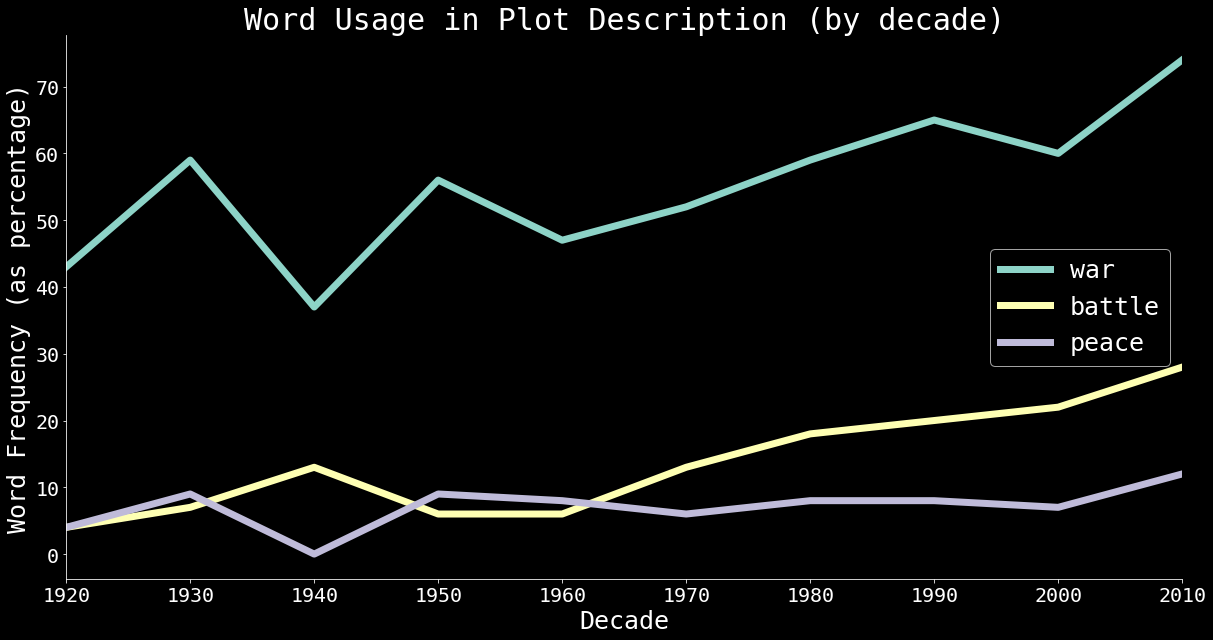

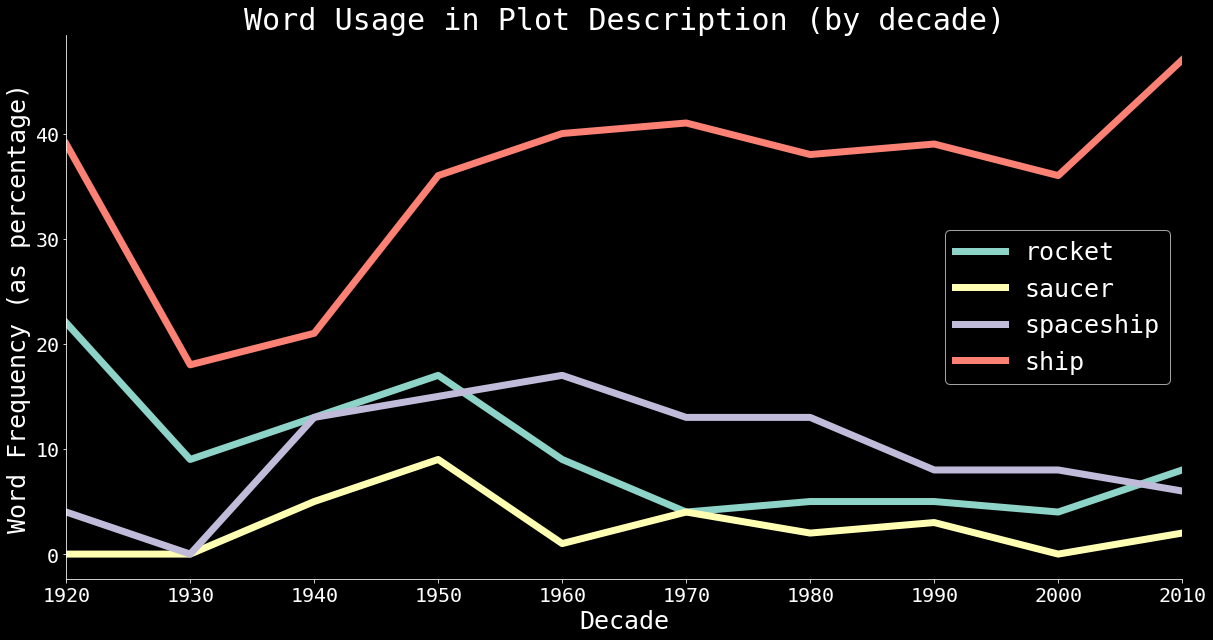

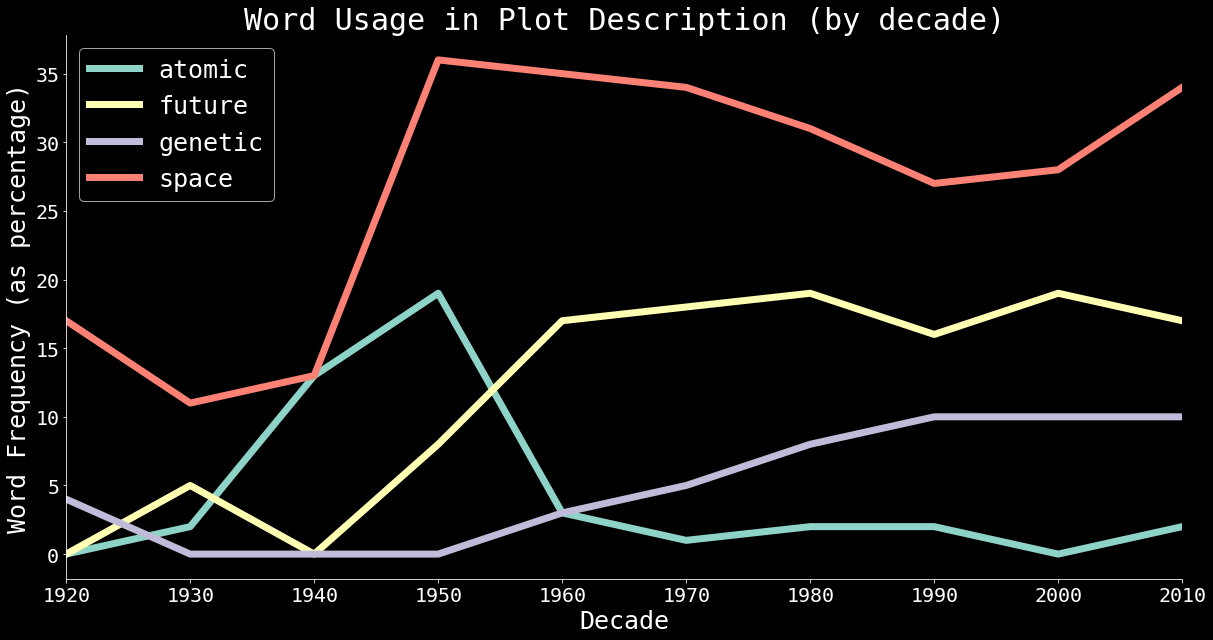

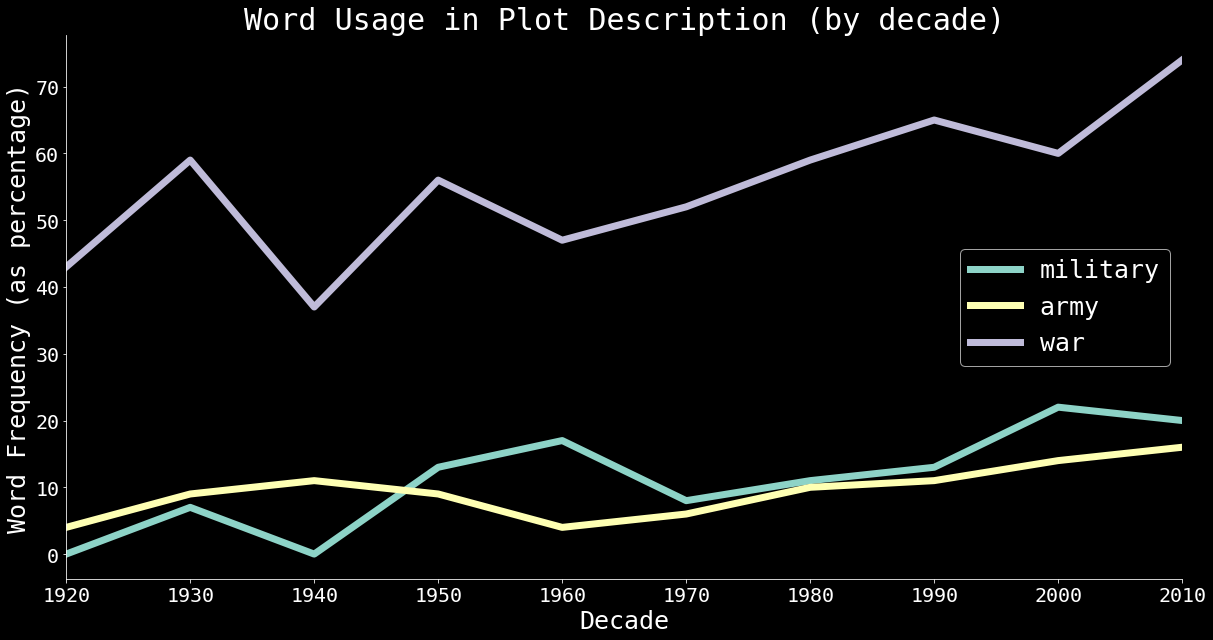

In [19]:
# yes I realize this could easily be a function. But you know those times
# where by the time you realize it it would take longer to do it that way?
# and it's the night before the project is due?
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = 20, 10
ax = df_percentages[beings].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('beings.png')
ax1 = df_percentages[people].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('people.png')
ax2 = df_percentages[devices].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('devices.png')
ax3 = df_percentages[war].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('war.png')
ax4 = df_percentages[vehicles].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('vehicles.png')
ax5 = df_percentages[concepts].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('concepts.png')
ax6 = df_percentages[entities].plot(linewidth=7.0)
plt.xlabel('Decade')
plt.ylabel('Word Frequency (as percentage)')
plt.title('Word Usage in Plot Description (by decade)')
plt.grid(False)
plt.rc('font', **font)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('entities.png')
plt.show()

# Below is all of the topic modeling aspects, none of which I ended up using for my presentation

In [21]:
def lemmatizing(df, series, remove_stop_words=True, remove_names=True):
    """
    lemmatizing a word means to make it into a simpler form. that way "walk" and "walking" are counted as
    the same word. This is important in topic modeling.
    Stop words are common words in the English language, when set to True, that means you want to remove
    stop words in your analysis. We exclude stop words for topic modeling, but not for counting words in a title.
    when a word is lemmatized, contractions are rightfully turned into different stems since 's = is
    however, in reality, all of those words are themselves stop words, so I want to exclude them
    question marks and the like are not helpful for our purpose of figuring out potential categories
    they are also  not "it's" should only count for one word in the title, so it makes sense to drop it the
    "'s" for simple counting of the title length as well.


    :param df: dataframe to be lemmatized
    :type df:
    :param series:
    :type series: pandas.series
    :param remove_stop_words:
    :type remove_stop_words: boolean True means remove stop words
    :return text: list of lemmatized texts
    :rtype: list
    """
    lemmatizer = WordNetLemmatizer()
    en_stop = get_stop_words('en')
    
    names = [word.replace('\n', '') for word in open('names.txt')][0].split(" ,")
    tokened_names = word_tokenize(names[0].lower())

    contractions = ["s","s","'",".",",","n't","'d","ll","re","ve","''", '–', "''", "...", "``",
     "''", "”", "“", "’", "(", ")", "?", ":", "t", ";", "d", "!", "-", "[", "]", "w", "#", "m"]


    texts = []  # list for tokenized documents in loop

    post_text = [i for i in df[series]]  # loop through document list

    print("Initializing tokenizer and lemmatizer ...")
    #print("  Progress:")
    for i, text in enumerate(post_text):
        #if not i % 50:
           # print("\t{}/{}".format(i, len(post_text)))

        tokens = word_tokenize(text.lower())  # clean and tokenize document string

        if remove_stop_words == True:  # lemmatize tokens and remove stop words
            lemmed_tokens = [lemmatizer.lemmatize(j) for j in tokens if not j in en_stop]
        else:
            lemmed_tokens = [lemmatizer.lemmatize(j) for j in tokens]

        contracted_tokens = [j for j in lemmed_tokens if not j in contractions]  # remove stemmed contractions
        
        if remove_names ==True:
            named_tokens = [k for k in contracted_tokens if not k in tokened_names]  # remove stemmed contractions
        else:
            named_tokens = contracted_tokens
        

        # add tokens to list
        texts.append(named_tokens)

    print("Lemmatizing Completed.")

    return texts

In [22]:
def topic_modeling(lem_list, n_topics=5, n_words=30, n_passes=3):
    """

    :param df:
    :type df: pandas dataframe
    :param lem_list:
    :type lem_list: list of lemmatized titles
    :param number_of_topics: number of topics you want. Do not reccomend more than 5
    :type number_of_topics: integer
    :param number_of_words: number of words related to each topic function will print out
    :type number_of_words: integer
    :param number_of_passes: passes through when create topics.
    :type number_of_passes: integer
    :return: dataframe with topics and associated probabilities for each observation
    :rtype: pd.Dataframe
    """
    print("Initializing Topic Modeling...")

    dictionary = corpora.Dictionary(lem_list)  # turn our tokenized documents into a id:term dictionary
    corpus = [dictionary.doc2bow(text) for text in lem_list]  # convert tokenized documents into a document-term matrix

    print("Generating Model...")
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=n_passes)
    #topics = ldamodel.print_topics(num_topics=n_topics, num_words=n_words)
    #print("Topics\n")

    #for i in range(n_topics):
        #print(f"  topic {topics[i][0]}: \n")
        #print(topics[i][1], "\n")

    return [ldamodel,corpus,dictionary]

In [23]:
def lems_and_topics(df, series, n_topics=5, n_words=30, n_passes=1, remove_stops = True, remove_stop_names = True):
    lems = lemmatizing(df, series, remove_stop_words = remove_stops, remove_names = remove_stop_names)
    topics = topic_modeling(lem_list = lems, n_topics=n_topics, n_words=n_words, n_passes=n_passes)
    print('Process complete.')
    return topics

In [24]:
topic_decades = ['topics_1920s_1930s','topics_1940s','topics_1950s','topics_1960s','topics_1970s',
                 'topics_1980s','topics_1990s','topics_2000s','topics_2010s']

In [26]:
df_1920s_1930s = df[(df.decade == '1920') | (df.decade == '1930')]
df_1940s = df[(df.decade == '1940')]
df_1950s = df[(df.decade == '1950')]
df_1960s = df[(df.decade == '1960')]
df_1970s = df[(df.decade == '1970')]
df_1980s = df[(df.decade == '1980')]
df_1990s = df[(df.decade == '1990')]
df_2000s = df[(df.decade == '2000')]
df_2010s = df[(df.decade == '2010')]
decade_dfs = [df_1920s_1930s, df_1940s, df_1950s, df_1960s,
              df_1970s,df_1980s,df_1990s,df_2000s,df_2010s]

In [ ]:
top = 4
passes = 3
topics_1920s_1930s = lems_and_topics(df_1920s_1930s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_1940s = lems_and_topics(df_1940s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_1950s = lems_and_topics(df_1950s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_1960s = lems_and_topics(df_1960s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_1970s = lems_and_topics(df_1970s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_1980s = lems_and_topics(df_1980s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_1990s = lems_and_topics(df_1990s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_2000s = lems_and_topics(df_2000s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)
topics_2010s = lems_and_topics(df_2010s, 'synopsis',n_topics = top, n_words = 20, n_passes =passes)

In [28]:
print('\n1930s and 1940s')
print(topics_1920s_1930s[0].print_topics())
print('\n1940s')
print(topics_1940s[0].print_topics())
print('\n1950s')
print(topics_1950s[0].print_topics())
print('\n1960s')
print(topics_1960s[0].print_topics())
print('\n1970s')
print(topics_1970s[0].print_topics())
print('\n1980s')
print(topics_1980s[0].print_topics())
print('\n1990s')
print(topics_1990s[0].print_topics())
print('\n2000s')
print(topics_2000s[0].print_topics())
print('\n2010s')
print(topics_2010s[0].print_topics())


1930s and 1940s
[(0, '0.012*"helius" + 0.011*"friede" + 0.008*"windegger" + 0.005*"mannfeldt" + 0.004*"evil" + 0.004*"monster" + 0.004*"film" + 0.004*"project" + 0.004*"turner" + 0.003*"wolf"'), (1, '0.010*"monster" + 0.006*"pretorius" + 0.005*"moreau" + 0.004*"help" + 0.004*"dr." + 0.003*"lota" + 0.003*"plane" + 0.003*"year" + 0.002*"island" + 0.002*"bride"'), (2, '0.007*"dr." + 0.007*"creature" + 0.005*"flash" + 0.005*"martial" + 0.005*"find" + 0.004*"world" + 0.004*"earth" + 0.004*"people" + 0.004*"take" + 0.004*"robot"'), (3, '0.012*"dr." + 0.005*"lanyon" + 0.005*"sir" + 0.005*"find" + 0.004*"carew" + 0.004*"police" + 0.004*"return" + 0.004*"father" + 0.004*"body" + 0.004*"house"')]

1940s
[(0, '0.010*"prokop" + 0.007*"dr." + 0.006*"doctor" + 0.005*"mueller" + 0.005*"laboratory" + 0.005*"death" + 0.004*"donovans" + 0.004*"named" + 0.004*"film" + 0.004*"experiment"'), (1, '0.012*"dr." + 0.007*"monster" + 0.006*"purple" + 0.006*"alien" + 0.006*"layton" + 0.006*"spaceship" + 0.006*"m

In [ ]:
# pyLDAvis is hard to get to show up on Github. But I definitely recommend using it
# for visualizing topics.

In [ ]:
print('\n**1930s**\n')
vis = pyLDAvis.gensim.prepare(topics_1920s_1930s[0], topics_1920s_1930s[1], topics_1920s_1930s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**1940s**\n')
vis = pyLDAvis.gensim.prepare(topics_1940s[0], topics_1940s[1], topics_1940s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**1950s**\n')
vis = pyLDAvis.gensim.prepare(topics_1950s[0], topics_1950s[1], topics_1950s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**1960s**\n')
vis = pyLDAvis.gensim.prepare(topics_1960s[0], topics_1960s[1], topics_1960s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**1970s**\n')
vis = pyLDAvis.gensim.prepare(topics_1970s[0], topics_1970s[1], topics_1970s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**1980s**\n')
vis = pyLDAvis.gensim.prepare(topics_1980s[0], topics_1980s[1], topics_1980s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**1990s**\n')
vis = pyLDAvis.gensim.prepare(topics_1990s[0], topics_1990s[1], topics_1990s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**2000s**\n')
vis = pyLDAvis.gensim.prepare(topics_2000s[0], topics_2000s[1], topics_2000s[2])
pyLDAvis.display(vis)

In [ ]:
print('\n**2010s**\n')
vis = pyLDAvis.gensim.prepare(topics_2010s[0], topics_2010s[1], topics_2010s[2])
pyLDAvis.display(vis)

# Dynamic Topic Modeling

In [35]:
from gensim import corpora, models
import gensim
import pyLDAvis.gensim
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy
from gensim.matutils import hellinger
import pyLDAvis

In [36]:
# LDA Dynamic topic modeling can be a little tricky in Python, because it requires
# a wrapper in C. I used a tutorial from the following to help quide
# me along https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html
# loading our corpus and dictionary
print("Initializing Topic Modeling...")
lems = lemmatizing(df, 'synopsis', remove_stop_words = True, remove_names = True)

dictionary = corpora.Dictionary(lems)  # turn our tokenized documents into a id:term dictionary
corpus = [dictionary.doc2bow(text) for text in lems]  # convert tokenized documents into a document-term matrix
# it's very important that your corpus is saved in order of your time-slices!

Initializing Topic Modeling...
Initializing tokenizer and lemmatizer ...
Lemmatizing Completed.


In [37]:
# dynamic topic modeling workflow

my_corpus = corpus
#my_timeslices = list(df.decade.value_counts())[::-1]
# below is just the number of observations per decade. However I couldn't use the code
# from above beause I needed to combine the first two decades of observations to even things out
my_timeslices = [23 + 38, 44, 116, 145, 151, 161, 192, 239, 254]
file = "/Users/Alexander/GA/data_capstone/dtm-master/bin/dtm-darwin64"
model = DtmModel(file,  my_corpus, my_timeslices, num_topics=3, id2word=dictionary, initialize_lda=True)

In [38]:
for i in range(9):
    topics = model.show_topic(topicid=1, time=i, num_words=10)
    print(f'\nTIME {i}')
    print(topics)


TIME 0
[(0.010571940711190001, 'dr.'), (0.0073541743566611084, 'alien'), (0.0069511840136373647, 'earth'), (0.0042345567751094345, 'ship'), (0.0041635083347487268, 'crew'), (0.0038726358845985174, 'space'), (0.0036781102412862458, 'find'), (0.0036292041284271149, 'take'), (0.0033031562750635815, 'scientist'), (0.0033015129648646057, 'return')]

TIME 1
[(0.010108623794811544, 'dr.'), (0.0078398212484811058, 'alien'), (0.0072629410103601973, 'earth'), (0.0044132976677408158, 'crew'), (0.0043587700806388798, 'ship'), (0.003994632445988848, 'space'), (0.0037138847833391147, 'find'), (0.0035825188302936926, 'take'), (0.0034387667471690231, 'human'), (0.0033966892078796367, 'scientist')]

TIME 2
[(0.0087986156269498506, 'dr.'), (0.0086050112338330251, 'alien'), (0.007673337595739912, 'earth'), (0.0047752353620098545, 'crew'), (0.0047111767500706853, 'ship'), (0.0042501672781768054, 'space'), (0.0038158049637795244, 'find'), (0.0037153999379450804, 'human'), (0.0035351811891220497, 'take'), 

In [ ]:
# you can use pyLDAvis with dynamic topic modeling!
# cool if your topics are actually dynamic and change over time (which mine barely did)
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=3, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)